In [1]:
# Import required libraries for loading data, visualization, encoding, and preprocessing.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load training and test CSV files and print their shapes.
train_path = "train.csv"
test_path  = "test.csv"
target_col = "price_class"
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("train_df:", train_df.shape)
print("test_df :", test_df.shape)

train_df: (41348, 7)
test_df : (7297, 7)


In [3]:
# Create a working copy of test data and validate that the target column exists.
test_temp = test_df.copy()
target_col = target_col if "target_col" in globals() else "price_class"

if target_col not in test_temp.columns:
    raise ValueError(f"'{target_col}' not found in test dataset.")

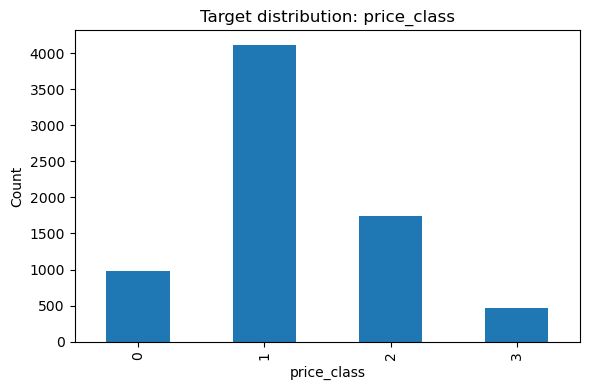

In [4]:
# Plot the target class distribution in the test dataset.
if target_col in test_temp.columns:

    plt.figure(figsize=(6, 4))
    test_temp[target_col].value_counts().sort_index().plot(kind="bar")
    plt.title("Target distribution: price_class")
    plt.xlabel("price_class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print(f"Target column '{target_col}' not found in train_clean.")

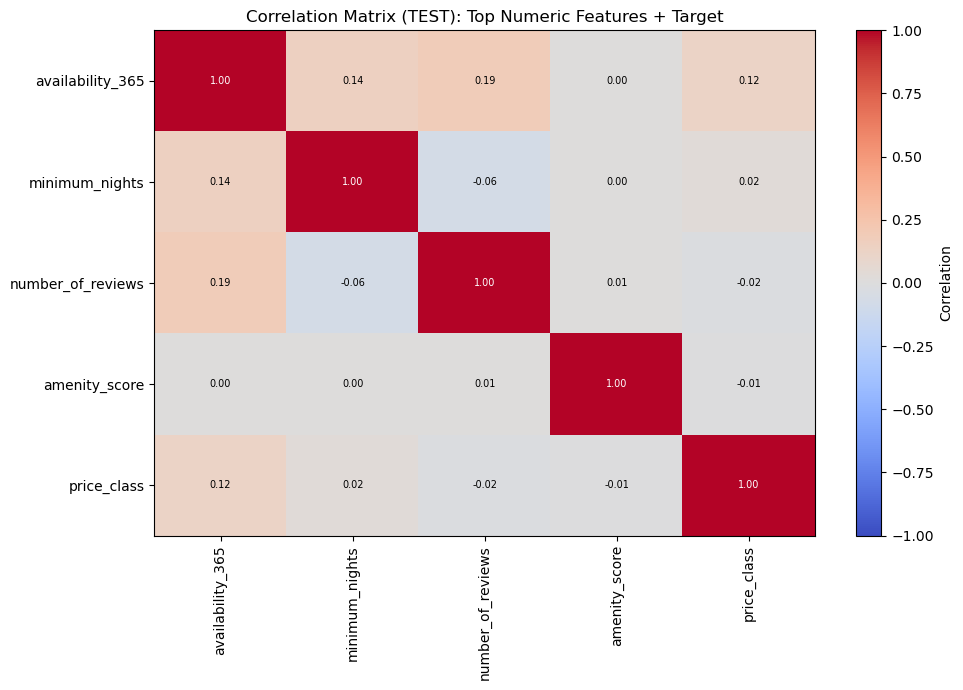

In [5]:
# Compute top numeric feature-target relationships and display a correlation heatmap.
target_is_numeric = pd.api.types.is_numeric_dtype(test_temp[target_col])

if target_is_numeric:
    y_rel = pd.to_numeric(test_temp[target_col], errors="coerce")
    num_cols_rel = test_temp.select_dtypes(include=["number"]).columns.drop(target_col, errors="ignore")
else:
    y_rel = pd.Series(pd.Categorical(test_temp[target_col]).codes, index=test_temp.index).replace(-1, np.nan)
    num_cols_rel = test_temp.select_dtypes(include=["number"]).columns

num_strength = (
    test_temp[num_cols_rel]
    .corrwith(y_rel)
    .abs()
    .dropna()
    .sort_values(ascending=False)
)

top_corr_cols = num_strength.head(10).index.tolist()

if len(top_corr_cols) >= 2:
    corr_df = test_temp[top_corr_cols].copy()
    corr_df[target_col if target_is_numeric else f"{target_col}_code"] = (
        pd.to_numeric(test_temp[target_col], errors="coerce") if target_is_numeric else y_rel
    )

    corr_mat = corr_df.corr(numeric_only=True)

    plt.figure(figsize=(10, 7))
    img = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
    plt.colorbar(img, label="Correlation")
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
    plt.yticks(range(len(corr_mat.index)), corr_mat.index)

    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[1]):
            val = corr_mat.iloc[i, j]
            txt_color = "white" if abs(val) >= 0.5 else "black"
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=7)

    plt.title("Correlation Matrix (TEST): Top Numeric Features + Target")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for this heatmap.")

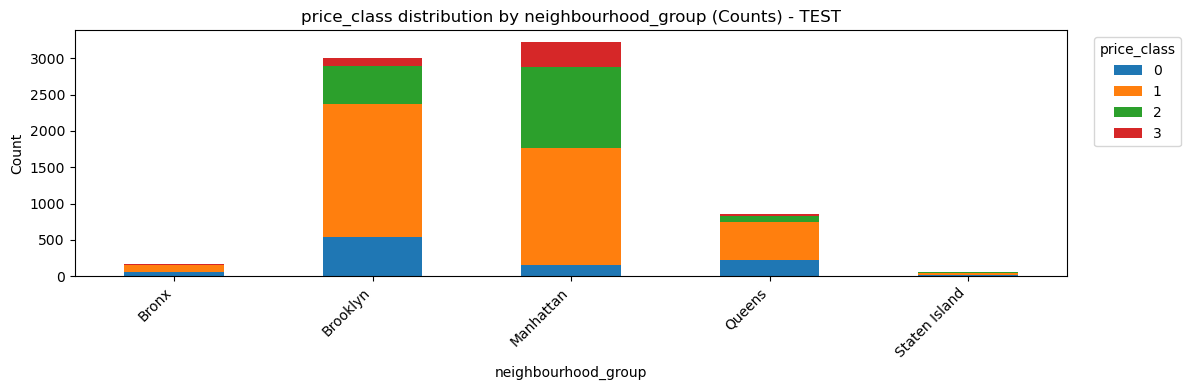

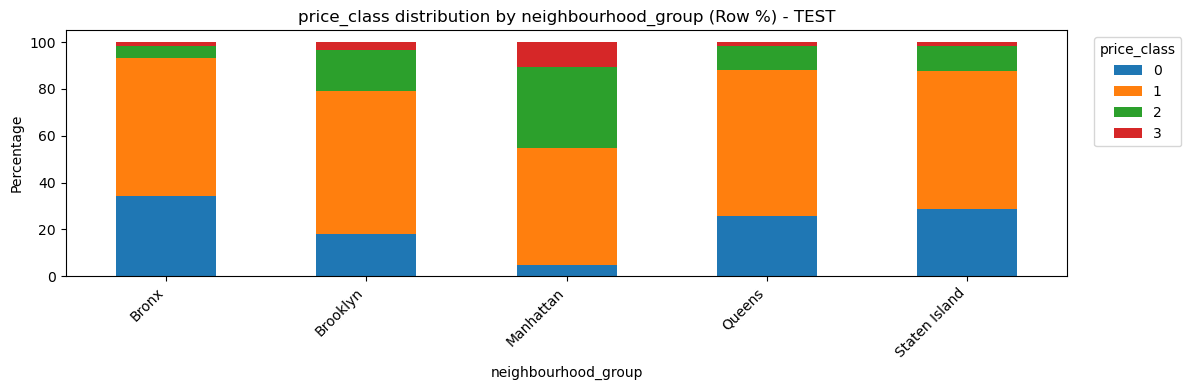

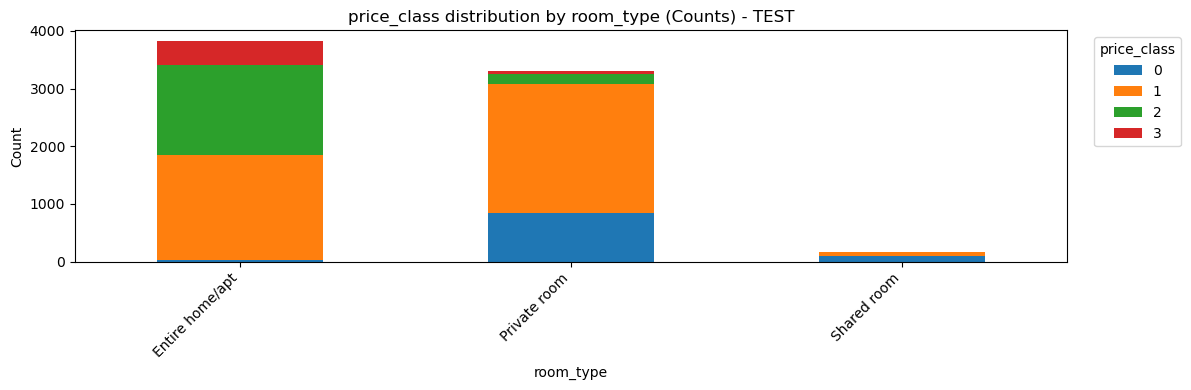

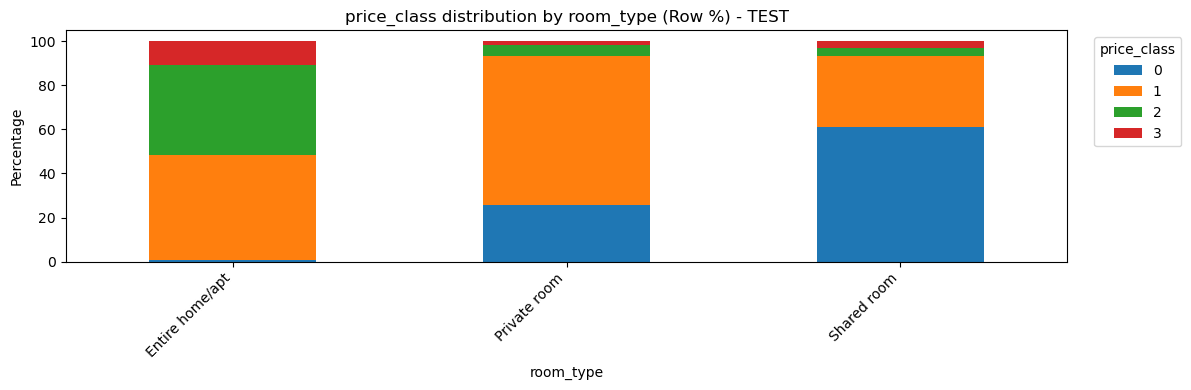

In [6]:
# Visualize target distribution across categorical features using counts and row percentages.
df_cat = test_temp.copy()
target = target_col

cat_cols_plot = df_cat.select_dtypes(include=["object", "category"]).columns.tolist()
if target in cat_cols_plot:
    cat_cols_plot.remove(target)

top_n = 15

if len(cat_cols_plot) == 0:
    print("No categorical columns found in test dataset.")
else:
    for col in cat_cols_plot:
        ct = pd.crosstab(df_cat[col].fillna("Missing").astype(str), df_cat[target])

        if len(ct) > top_n:
            top_levels = ct.sum(axis=1).sort_values(ascending=False).head(top_n - 1).index
            ct_top = ct.loc[top_levels]
            ct_other = ct.drop(index=top_levels).sum().to_frame().T
            ct_other.index = ["Other"]
            ct = pd.concat([ct_top, ct_other])

        ax = ct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target} distribution by {col} (Counts) - TEST")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
        ax = pct.plot(kind="bar", stacked=True, figsize=(12, 4))
        ax.set_title(f"{target} distribution by {col} (Row %) - TEST")
        ax.set_xlabel(col)
        ax.set_ylabel("Percentage")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title=target, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

<Figure size 700x400 with 0 Axes>

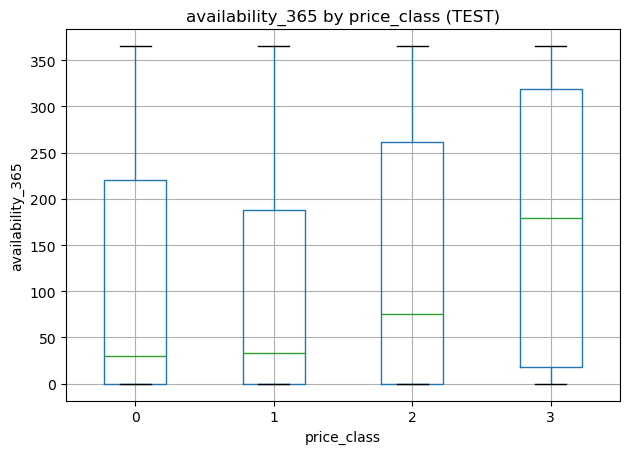

<Figure size 700x400 with 0 Axes>

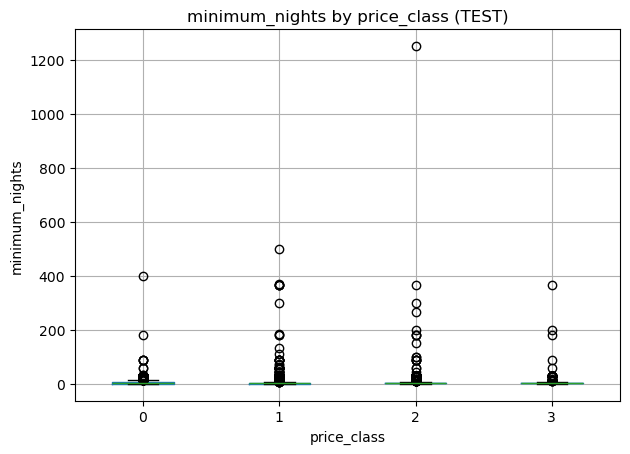

<Figure size 700x400 with 0 Axes>

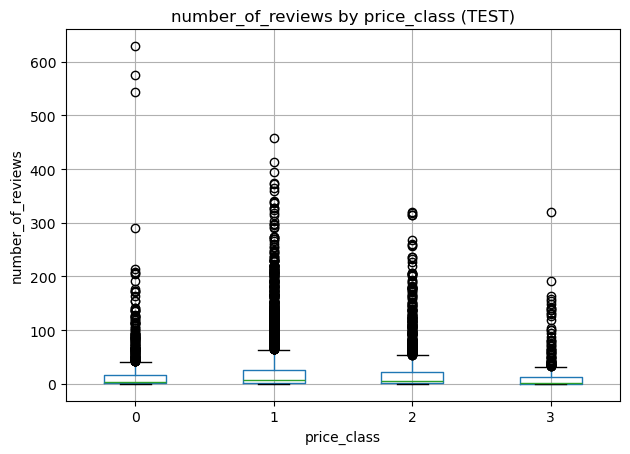

<Figure size 700x400 with 0 Axes>

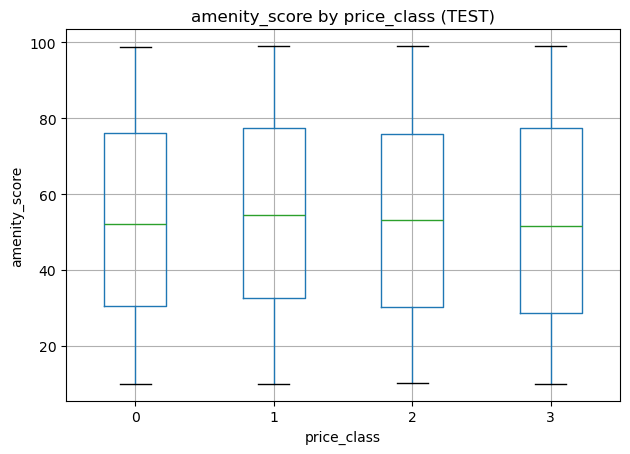

In [7]:
# Plot boxplots of top numeric features against the target on test data.
top_num = num_strength.head(6).index.tolist()
for col in top_num:
    if target_is_numeric:
        plt.figure(figsize=(7, 4))
        test_temp.boxplot(column=col, by=target_col)
        plt.title(f"{col} by {target_col} (TEST)")
        plt.suptitle("")
        plt.xlabel(target_col)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

Numeric columns: Index(['minimum_nights', 'amenity_score', 'number_of_reviews',
       'availability_365'],
      dtype='object')


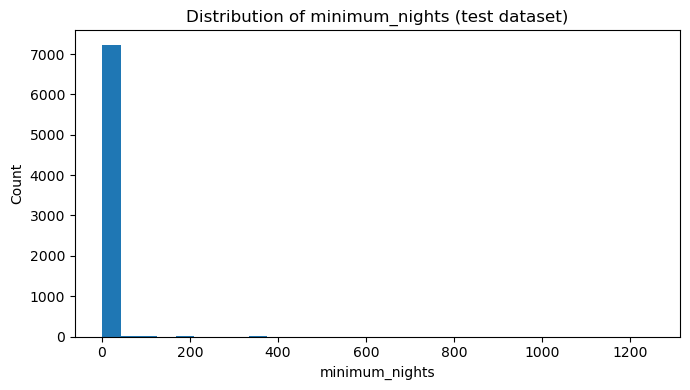

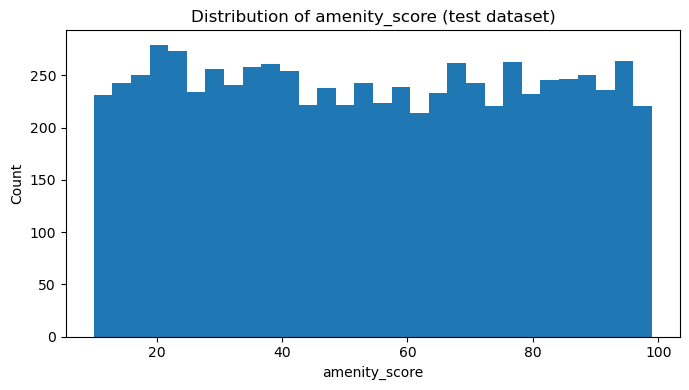

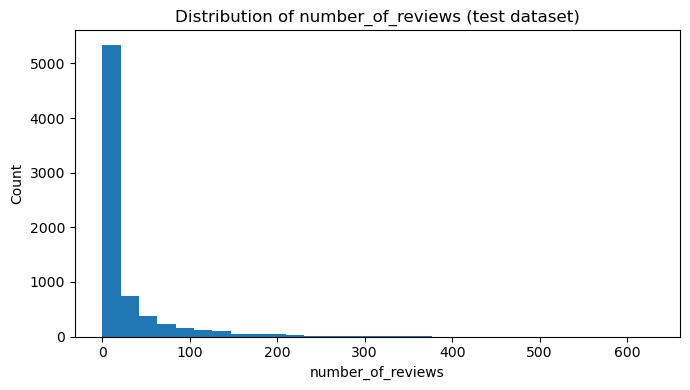

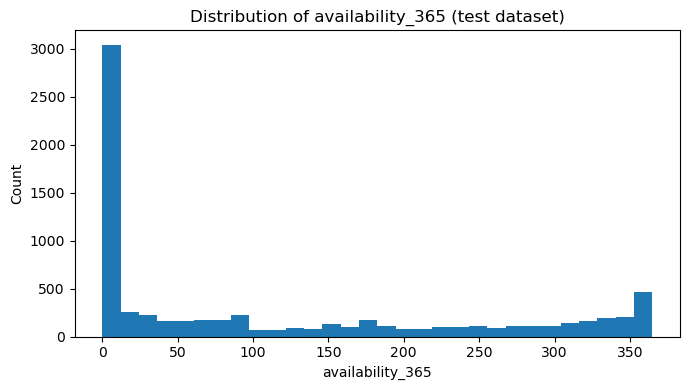

In [8]:
# Plot histograms for numeric feature distributions in the test dataset.
df_num = test_temp.copy()
target = target_col

num_cols = (
    num_cols_rel.copy()
    if "num_cols_rel" in globals()
    else df_num.select_dtypes(exclude=["object", "category"]).columns.tolist()
)

if target in num_cols:
    num_cols.remove(target)

print("Numeric columns:", num_cols)

if len(num_cols) == 0:
    print("No numeric columns found in test dataset.")
else:
    for col in num_cols:
        plt.figure(figsize=(7, 4))
        plt.hist(df_num[col].dropna(), bins=30)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col} (test dataset)")
        plt.tight_layout()
        plt.show()